In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset

import matplotlib.image as mpimg
from matplotlib import cm
import matplotlib.animation as ani
from scipy.integrate import odeint
import pandas as pd
import copy

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
isotopes = Dataset('climatology/xnapa_isotopes.nc', "a")
precipitation = Dataset('climatology/xnapa_precip.nc', "a")
surface_temperature = Dataset('climatology/xnapa_temp.nc', "a")
sea_level_pressure = Dataset('climatology/xnapa_slp.nc', "a")

In [3]:
lat = isotopes.variables["latitude"][:].data[1:-1]
long = isotopes.variables["longitude"][:].data
t = isotopes.variables["t"][:].data

trash = [626, 0]

In [5]:
do18 = []
precip = []
temp = []
slp = []
for i in range(len(t)-1):
    do18.append(isotopes.variables["dO18"][i][0].data[1:-1].reshape(71*96))
    precip.append(precipitation.variables["precip"][i][0].data[1:-1].reshape(71*96))
    temp.append(surface_temperature.variables["temp_1"][i][0].data[1:-1].reshape(71*96))
    slp.append(sea_level_pressure.variables["p"][i][0].data[1:-1].reshape(71*96))
    
do18 = pd.DataFrame(np.delete(np.delete(np.asarray(do18), 0, 0), 626, 0)[:1000])
precip = pd.DataFrame(np.delete(np.delete(np.asarray(precip), 0, 0), 626, 0)[:1000])
temp = pd.DataFrame(np.delete(np.delete(np.asarray(temp), 0, 0), 626, 0)[:1000])
slp = pd.DataFrame(np.delete(np.delete(np.asarray(slp), 0, 0), 626, 0)[:1000])

In [6]:
def mlr_pca_slp(temp, precip, slp, do18, n_temp=20, n_precip=20, n_slp=20, n_y=20, train_proportion=0.9, random=True):
    
    if random:
        random_idx = np.random.permutation(do18.index.values)
    
        temp = temp.reindex(random_idx)
        precip = precip.reindex(random_idx)
        do18 = do18.reindex(random_idx)
    
    #divide training and test data
    do18_train = do18[:int(np.floor(train_proportion*len(do18)))].reset_index(drop=True)
    do18_test = do18[int(np.floor(train_proportion*len(do18))):].reset_index(drop=True)

    temp_train = temp[:int(np.floor(train_proportion*len(temp)))].reset_index(drop=True)
    temp_test = temp[int(np.floor(train_proportion*len(temp))):].reset_index(drop=True)
    
    slp_train = slp[:int(np.floor(train_proportion*len(slp)))].reset_index(drop=True)
    slp_test = slp[int(np.floor(train_proportion*len(slp))):].reset_index(drop=True)

    precip_train = precip[:int(np.floor(train_proportion*len(precip)))].reset_index(drop=True)
    precip_test = precip[int(np.floor(train_proportion*len(precip))):].reset_index(drop=True)
    
    #define scalers
    scaler_temp = StandardScaler().fit(temp)
    scaler_precip = StandardScaler().fit(precip)
    scaler_slp = StandardScaler().fit(slp)
    scaler_do18 = StandardScaler().fit(do18)
    
    #scale data
    do18_train_scaler = scaler_do18.transform(do18_train)
    do18_test_scaler = scaler_do18.transform(do18_test)

    temp_train_scaler = scaler_temp.transform(temp_train)
    temp_test_scaler = scaler_temp.transform(temp_test)
    
    slp_train_scaler = scaler_slp.transform(slp_train)
    slp_test_scaler = scaler_slp.transform(slp_test)

    precip_train_scaler = scaler_precip.transform(precip_train)
    precip_test_scaler = scaler_precip.transform(precip_test)
    
    #define pcas and fit data
    pca_temp = PCA(n_components=n_temp).fit(np.append(temp_train_scaler, temp_test_scaler, axis=0))
    pca_precip = PCA(n_components=n_precip).fit(np.append(precip_train_scaler, precip_test_scaler, axis=0))
    pca_slp = PCA(n_components=n_slp).fit(np.append(slp_train_scaler, slp_test_scaler, axis=0))
    pca_do18 = PCA(n_components=n_y).fit(np.append(do18_train_scaler, do18_test_scaler, axis=0))
    
    #transform data
    do18_train_pc = pca_do18.transform(do18_train_scaler)
    do18_test_pc = pca_do18.transform(do18_test_scaler)

    temp_train_pc = pca_temp.transform(temp_train_scaler)
    temp_test_pc = pca_temp.transform(temp_test_scaler)
    
    slp_train_pc = pca_slp.transform(slp_train_scaler)
    slp_test_pc = pca_slp.transform(slp_test_scaler)

    precip_train_pc = pca_precip.transform(precip_train_scaler)
    precip_test_pc = pca_precip.transform(precip_test_scaler)
    
    
    X_train = np.append(np.append(temp_train_pc, precip_train_pc, axis=1), slp_train_pc, axis=1)
    X_test = np.append(np.append(temp_test_pc, precip_test_pc, axis=1), slp_test_pc, axis=1)

    Y_train = do18_train_pc
    Y_test = pd.DataFrame(do18_test_pc)
    
    Y = pd.DataFrame(np.append(Y_train, Y_test, axis=0))
    
    #train model
    regressor = LinearRegression().fit(X_train, Y_train)
    
    #predict test data
    pred_pc = pd.DataFrame(regressor.predict(X_test))
    pred_norm = pd.DataFrame(pca_do18.inverse_transform(pred_pc))
    pred = pd.DataFrame(scaler_do18.inverse_transform(pred_norm))
    
    
    #return pca and final data
    return pred_pc, pred_norm, pred, Y_test, pd.DataFrame(do18_test_scaler), do18_test

In [7]:
pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = mlr_pca_slp(temp, precip, slp, do18, n_temp=20, n_precip=20, n_y=20)

In [8]:
pred_list = copy.deepcopy(pred)
test_list = copy.deepcopy(do18_test)

In [9]:
for i in range(100):
    print(i)
    pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = mlr_pca_slp(temp, precip, slp, do18, n_temp=20, n_precip=20, n_y=20)
    pred_list = pred_list.append(pred)
    test_list = test_list.append(do18_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [10]:
pred_list = pred_list.reset_index(drop=True)
test_list = test_list.reset_index(drop=True)

In [11]:
rmse_geolist = []
for pixel in test_list.columns.values:
    rmse_pixel = mean_squared_error(pred_list[pixel].values, test_list[pixel].values, squared=False)
    rmse_geolist.append(rmse_pixel)
    
df_rmse_geolist = pd.DataFrame(np.asarray(rmse_geolist).reshape(71,96))

In [12]:
std = pd.DataFrame(do18.std().values.reshape(71,96))

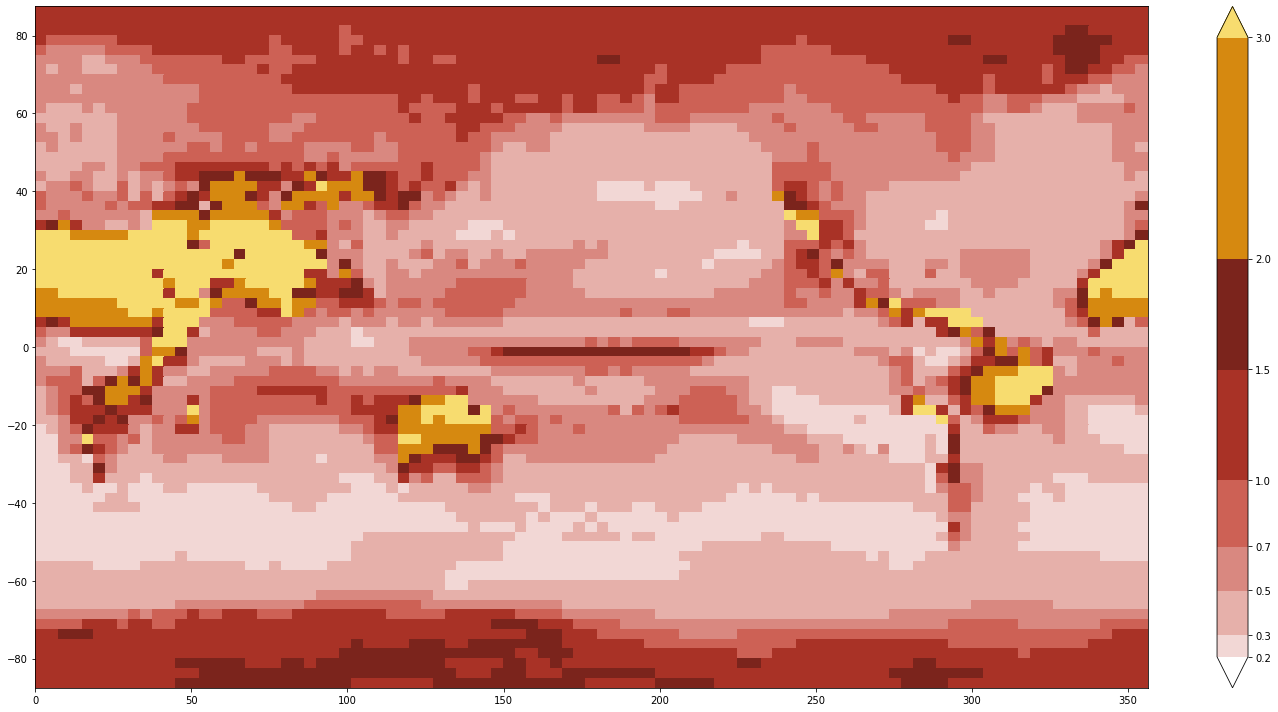

In [13]:
para = df_rmse_geolist.values

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
fig = plt.figure()

colors = ["#f2d7d5", "#e6b0aa", "#d98880", "#cd6155", "#a93226", "#7b241c", "#d68910"]
bounds = [0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3]
cmap= matplotlib.colors.ListedColormap(colors)
cmap.set_under("#ffffff")
cmap.set_over("#f7dc6f")
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

layer = plt.pcolor(long, lat, para, cmap=cmap, vmin=0.1, vmax=3, norm=norm)
plt.tight_layout()

cbar = plt.colorbar(
    layer,
    extend="both", 
    ticks=bounds, 
    spacing='proportional'
)

In [14]:
file = open("rmse_mlr_pca_slp.txt", "w")
dump = "\n".join(df_rmse_geolist.values.reshape(71*96).astype(str).tolist())
file.write(dump)

129717

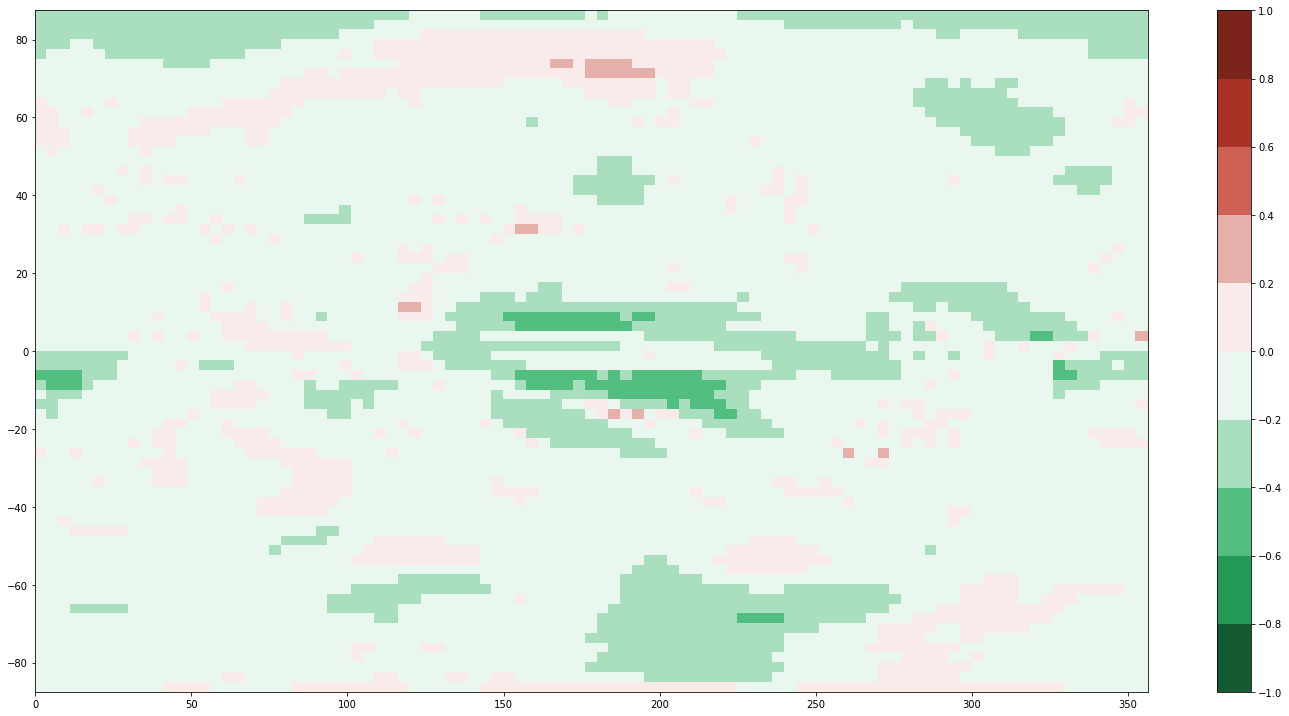

In [15]:
para = df_rmse_geolist/std -1

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
fig = plt.figure()

colors = ["#145a32", "#229954", "#52be80", "#a9dfbf",  "#e9f7ef", "#f9ebea", "#e6b0aa", "#cd6155", "#a93226", "#7b241c"]
bounds = [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1] 
cmap= matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

layer = plt.pcolor(
    long, lat, para, 
    cmap=cmap,
    vmin=-1, vmax=1, 
    norm=norm
)
plt.tight_layout()

cbar = plt.colorbar(
    layer,
    ticks=bounds, 
    spacing='proportional'
)

In [16]:
file = open("rmse_norm_mlr_pca_slp.txt", "w")
dump = "\n".join((df_rmse_geolist/std -1).values.reshape(71*96).astype(str).tolist())
file.write(dump)

142611

In [42]:
para.std().std()

0.01601438535232376